Implémentation du papier de recherche "(S)GD over Diagonal Linear Networks:
Implicit Bias, Large Stepsizes and Edge of Stability"

In [34]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Données synthétiques

On génère les données synthétiques pour avoir un $\beta_{sparse}$ à support non nul sur k composantes et nul sur le reste$

In [35]:
def generate_data(n, d, k, sigma=0.0):
    X = torch.randn(n, d, device=device)
    
    w_star = torch.zeros(d, 1, device=device)
    indices = torch.randperm(d, device=device)[:k]
    w_star[indices] = torch.randn(k, 1, device=device) 
    
    y = X @ w_star + sigma * torch.randn(n, 1, device=device)
    
    return X, y, w_star

n, d, k = 40, 100, 3
X, y, w_star = generate_data(n, d, k)

train_dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialisation de la classe du Diagonal Linear Net

In [36]:
class DLN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, alpha = 1.0, uniform = True):
        super(DLN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.alpha = alpha
        self.uniform = uniform

        self._initialize_weights()

    def _initialize_weights(self):

        nn.init.zeros_(self.fc1.weight)
        nn.init.zeros_(self.fc2.weight)
        if self.fc1.bias is not None: nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None: nn.init.zeros_(self.fc2.bias)

        with torch.no_grad():
            min_dim = min(self.fc1.in_features, self.fc1.out_features)

            if self.uniform:
                vals = torch.full((min_dim,), self.alpha, device=self.fc1.weight.device)
            
            else:
                vals = torch.rand(min_dim, device=self.fc1.weight.device) * 2 * self.alpha
            
            indices = torch.arange(min_dim, device=self.fc1.weight.device)
            self.fc1.weight[indices, indices] = vals
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# Fonction d'entrainement du DLN

In [37]:
def train_dln(model, X, y, lr, epochs, mode='gd', batch_size=None, threshold=1e-5):
    criterion = nn.MSELoss()
    
    if mode == 'sgd' and batch_size is None:
        batch_size = 1
        
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    mask = torch.eye(model.fc1.weight.shape[0], device=device)
    
    if mode == 'gd':
        data_loader = [(X, y)] 
    else:
        dataset = torch.utils.data.TensorDataset(X, y)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
    for epoch in range(epochs):
        for batch_X, batch_y in data_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            
            
            with torch.no_grad():
                model.fc1.weight.grad *= mask
            
            optimizer.step()
            
        if loss.item() < threshold:
            break
            
    return model

# Experimentations

## Exp 1

La première expérimentation correspond à la figure 1. On va augmenter le stepsize jusqu'au Edge of Stability

In [ ]:
n = 20
d = 30
k = 3
alpha = 0.1

X, y, w_star = generate_data(n, d, k)

stepsizes = np.logspace(-2, 0.5, 20)

test_losses_gd = []
test_losses_sgd = []

print("Lancement de l'expérience")

for lr in stepsizes:
    model_gd = DLN(d, 1, d, alpha=alpha, uniform=True).to(device)
    train_dln(model_gd, X, y, lr=lr, epochs=5000, mode='gd', threshold=1e-5)
    
    with torch.no_grad():
        w1 = model_gd.fc1.weight.diag()
        w2 = model_gd.fc2.weight.flatten()
        beta_gd = (w1 * w2).unsqueeze(1)
        error_gd = torch.norm(beta_gd - w_star)**2
        test_losses_gd.append(error_gd.item())

    model_sgd = DLN(d, 1, d, alpha=alpha, uniform=True).to(device)
    train_dln(model_sgd, X, y, lr=lr, epochs=5000, mode='sgd', batch_size=1, threshold=1e-5)
    
    with torch.no_grad():
        w1 = model_sgd.fc1.weight.diag()
        w2 = model_sgd.fc2.weight.flatten()
        beta_sgd = (w1 * w2).unsqueeze(1)
        error_sgd = torch.norm(beta_sgd - w_star)**2
        test_losses_sgd.append(error_sgd.item())


Lancement de l'expérience (peut prendre quelques secondes)...


ValueError: 
Test loss at convergence ($||eta - eta^*||^2$)
                          ^
ParseException: Expected end of text, found '$'  (at char 26), (line:1, col:27)

<Figure size 800x500 with 1 Axes>

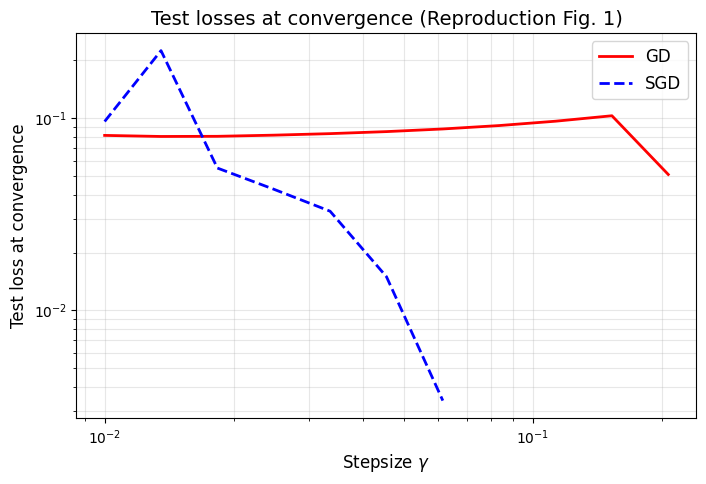

In [39]:
plt.figure(figsize=(8, 5))
plt.loglog(stepsizes, test_losses_gd, 'r-', label='GD', linewidth=2)
plt.loglog(stepsizes, test_losses_sgd, 'b--', label='SGD', linewidth=2)

plt.xlabel('Stepsize $\gamma$', fontsize=12)
plt.ylabel('Test loss at convergence', fontsize=12)
plt.title('Test losses at convergence (Reproduction Fig. 1)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()